# Week 5: Optical Flow

**The exercise of this week is about Optical Flow. First load the following libraries that will be necessary.**

In [2]:
!pip install --user scipy
!pip install --user scikit-image

In [3]:
%matplotlib inline
from skimage.io import imread
from scipy import signal,ndimage
import numpy as np
import time
import scipy.io as sio
from matplotlib.pyplot import imshow,show,figure
import skimage.transform as tf
import IPython
import flow_vis

**We will compute the optical flow between two images. Load the two images `frame1.png` and `frame2.png`.**

max flow: 4.6157 flow range: u = -4.576 .. 2.575; v = -2.575 .. 2.919



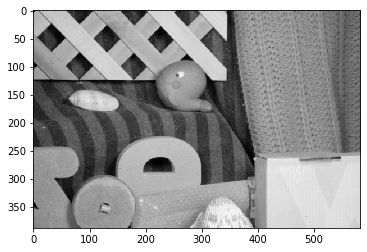

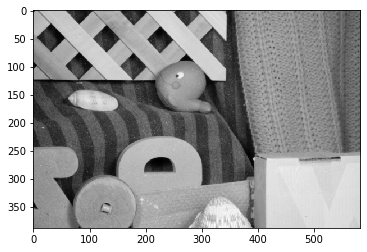

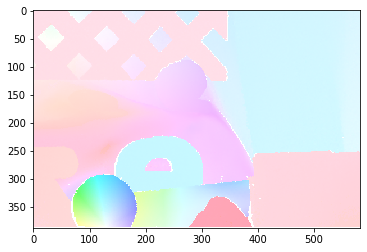

In [4]:
image1 = imread('frame1.png',as_gray=True)
image2 = imread('frame2.png',as_gray=True)
figure()
imshow(image1, cmap='gray')
figure()
imshow(image2, cmap='gray')

flow_gt = sio.loadmat('flow_gt.mat')['groundTruth']
flow_image_gt = flow_vis.flow_to_color(flow_gt)
figure()
imshow(flow_image_gt, cmap='gray')

## Part A: Lukas-Knade Algorithm
We estimate the optical flow $u,v$ by solving the lineary system 
$$I_xu+I_yv+I_t=0$$

The spatial partial $I_x$ and $I_y$ derivatives are computed by convolving the patches with a 1D-kernel $[-1,1]$ and taking the average between the two patches. In order to make the estimates more robust, we furthermore smooth the derivatives with a 1D-kernel $\frac{1}{2}[1,1]$. These steps can be combined in a single convolution. For example the partial
derivative in x-direction between patches I_1 and I_2 is given by 

$$I_x = (I_1+I_2)*\frac{1}{4}\begin{bmatrix}-1 & 1\\ -1 & 1\end{bmatrix}$$

where $∗$ denotes the 2D convolution operator. Analogously, the partial temporal derivative is given by 

$$I_t = (I_2-I_1)*\frac{1}{4}\begin{bmatrix}1 & 1\\ 1 & 1\end{bmatrix}.$$

**Complete the missing lines to define the convolution kernels and to compute the partial derivatives. You can use `signal.convolve2d(x, kernel, mode='same')` for convolution.** 


After computing the partial derivatives, we can estimate the optical flow for each patch by solving the following linear system
$$ A^TAx=A^Tb$$ with
$$A = \begin{bmatrix}p_x & p_y\end{bmatrix} \text{and } b = -p_t$$
**Complete the missing lines to define and solve the linear system. You can use `np.linalg.solve` to solve the linear system.** 


In [82]:
def lukas_kanade(I1, I2, window_size=5):
    
    w = window_size//2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1 = I1/255.  # normalize pixels
    I2 = I2/255.   # normalize pixels
    
    # Your codes here. Define convolution kernels.
    kernel_x = 1/4 * np.array([[-1, 1], [-1, 1]])
    kernel_y = 1/4 * np.array([[1, 1], [-1, -1]])
    kernel_t = 1/4 * np.array([[1, 1], [1, 1]])
    
    # Your codes here. Compute partial derivatives.
    Ix = signal.convolve2d(I1 + I2, kernel_x, mode='same')
    Iy = signal.convolve2d(I1 + I2, kernel_y, mode='same')
    It = signal.convolve2d(I2 - I1, kernel_t, mode='same')
    
    u = np.zeros(I1.shape)
    v = np.zeros(I1.shape)
    for i in range(w, I1.shape[0] - w):
        for j in range(w, I1.shape[1] - w):

            # obtain partial derivatives for current patch
            px = Ix[i - w:i + w + 1, j - w:j + w + 1].flatten()
            py = Iy[i - w:i + w + 1, j - w:j + w + 1].flatten()
            pt = It[i - w:i + w + 1, j - w:j + w + 1].flatten()
            
            # Your codes here. Compute optical flow.
            A = np.array([px, py]).T
            b = -pt
            nu = np.linalg.solve(np.matmul(A.T, A), np.matmul(A.T, b[:, None]))
            
            u[i, j] = nu[0]
            v[i, j] = nu[1]

    return u,v

**Now let's test the function.** The first plot shows the ground-truth and the second shows the estimation. The excution takes some time (~60s on Azure and ~5s on laptops).

**Q: What is the influence of window size and why?**

Elapsed time:  6.064697980880737
max flow: 9.5809 flow range: u = -5.516 .. 3.536; v = -7.135 .. 9.328



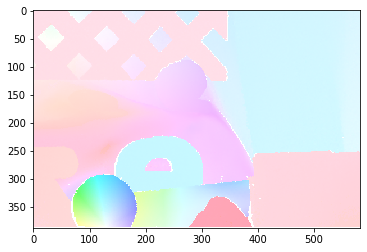

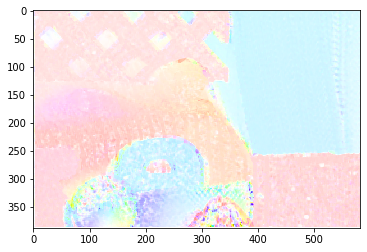

In [83]:
t = time.time()
u, v = lukas_kanade(image1, image2, window_size=5)
print('Elapsed time: ', time.time()-t)

figure()
imshow(flow_image_gt, cmap='gray')

figure()
flow_image = flow_vis.flow_to_color(np.stack([u,v],axis=-1))
imshow(flow_image,cmap='gray')

## Part B: Lukas-Kanade with Pyramid

In previous part, the optical flow of each pixel is computed only based on a small neighbouring region. Therefore the algorithm cannot deal with large displacement. As a solution, we can apply the algorithm iteratively from coarse to fine.

We construct a image pyramid, apply the optical flow algorithm at each level starting from the coarsest resolution and propagate the computed flow to the next level. The propagation is done by first warping image1 with the estimated flow and then estimate the residual flow between the image2 and warped image1. You can use `ndimage.map_coordinates(image, [new_ys, new_xs])` for image warping.

** Complete the following lines for image warping and optical flow estimation & updating. **

lel (194, 292) (194, 292)
max flow: 5.4253 flow range: u = -5.425 .. 1.643; v = -1.969 .. 2.206

lel (388, 584) (388, 584)
max flow: 22.0774 flow range: u = -11.146 .. 16.416; v = -14.763 .. 13.627



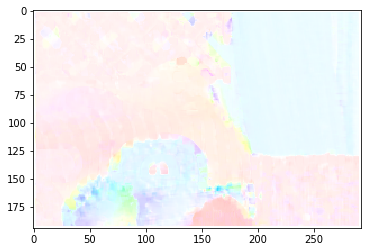

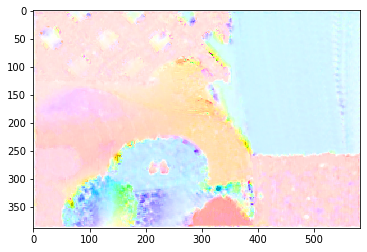

In [94]:
num_layers = 1
downscale = 2

# Construct image pyramids
pyramids1 = tf.pyramid_gaussian(image1, max_layer=num_layers, downscale=downscale, sigma=1)
pyramids2 = tf.pyramid_gaussian(image2, max_layer=num_layers, downscale=downscale, sigma=1)

u = np.zeros(image1.shape)
v = np.zeros(image1.shape)
for im1,im2 in zip(reversed(list(pyramids1)),reversed(list(pyramids2))):

    # Upsampling and upscaling current flow estimation.
    h,w = im1.shape
    u = h/u.shape[0] * tf.resize(u, (h,w), order=1)
    v = h/u.shape[0] * tf.resize(v, (h,w), order=1)

    # Your codes here. Warp image.
    yy, xx = np.mgrid[:h, :w]
    print("lel", yy.shape, v.shape)
    im1_warp = ndimage.map_coordinates(im1, [yy + v, xx + u])

    # Your codes here. Update optical flow.
    du, dv = lukas_kanade(im1_warp, im2)
    u += du
    v += dv

    flow_image = flow_vis.flow_to_color(np.stack([u,v],axis=-1))
    figure()
    imshow(flow_image,cmap='gray')

## Part C: Frame Extrapolation with Optical Flow

Optical flow can be used for frame extrapolation. Given the two frames, we can predict the next few frames (assuming constant pixel motions). This can be done by scaling the optical flow and warping the image accordingly. 

** Complete the following lines for frame extrapolation. **

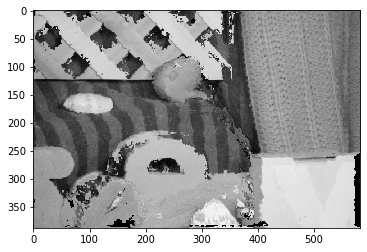

In [98]:
h, w = image1.shape[:2]
yy, xx = np.mgrid[:h, :w]
flow = np.stack([u, v], axis = -1)

for i in range(1,10):
     
    # Your codes here. Extrapolate frames.
    rows = yy + flow[:,:,1] * i
    cols = xx + flow[:,:,0] * i
    image1_warp = ndimage.map_coordinates(image1, [rows, cols])
    
    imshow(image1_warp,cmap='gray')
    
    IPython.display.clear_output(True)
    
    show()